In [1]:
import numpy as np
np.set_printoptions(precision=8)
from matplotlib import pyplot as plt
from gnuradio import OFDM_OOT
from scipy import interpolate

In [3]:
nfft = 512
nguard = 32
ofdm_sym_sz = nfft + nguard
frame_sym_cnt = 6

seqN_len = 32
seqN_N = 2
preamble_sz = seqN_len*seqN_N

frame_sz = preamble_sz + ofdm_sym_sz*frame_sym_cnt

pilot_carriers_idx_group_0 = np.arange(5, 25, 4)
pilot_carriers_idx_group_1 = nfft + np.arange(-5, -25, -4)
pilot_carriers_idx = np.hstack([pilot_carriers_idx_group_0 , pilot_carriers_idx_group_1])
pilot_values_group_0 = 1.4 * np.exp(-2j*np.pi*np.arange(pilot_carriers_idx_group_0.size)/2)
pilot_values_group_1 = 1.4 * np.exp(-2j*np.pi*np.arange(pilot_carriers_idx_group_1.size)/2)
pilot_values = np.hstack([pilot_values_group_0, pilot_values_group_1])

data_carriers_idx = np.setdiff1d(np.hstack([np.arange(5, 25) , np.arange(-5, -25, -1)]), pilot_carriers_idx)
ofdm_sym = OFDM_OOT.random_ofdm_sym(nfft, data_carriers_idx, pilot_carriers_idx, pilot_values, data_modulation='qpsk')


data_frames = np.fromfile(open("rx_tx_records/frames_last_record.bin"), dtype=np.complex64).reshape((-1, frame_sz))
data_coarce_sync = np.fromfile(open("rx_tx_records/coarse_sync_last_record.bin"), dtype=np.complex64).reshape((-1, nfft))
data_precise_sync = np.fromfile(open("rx_tx_records/precise_sync_last_record.bin"), dtype=np.complex64).reshape((-1, nfft))

In [4]:
idx_st = -200
idx_range_len = 10

for frame_idx in range(idx_st, idx_st + idx_range_len):
    frame_t = data_frames[frame_idx]
    sco_est = OFDM_OOT.ofdm_sco_sync.sco_estimate_frame(frame_t[preamble_sz:], nfft, nguard, frame_sym_cnt, pilot_carriers_idx)
    print(sco_est)

0.00016009633429672852
0.0001587880817943677
0.00016041648989315553
0.0001604434137860691
0.00015941856690569636
0.0001599115741601367
0.00016007552711648843
0.0001603143864358897
0.00015860640690374853
0.00016050624636429145


In [5]:
frame_idx = -200
frame_t = data_frames[frame_idx]
sco_est = OFDM_OOT.ofdm_sco_sync.sco_estimate_frame(frame_t[preamble_sz:], nfft, nguard, frame_sym_cnt, pilot_carriers_idx)

tck_real = interpolate.splrep(np.arange(frame_t.size), frame_t.real)
tck_imag = interpolate.splrep(np.arange(frame_t.size), frame_t.imag)
xnew = np.arange(frame_t.size)*(1-sco_est)
#ynew = interpolate.splev(xnew, tck_real) + 1j*interpolate.splev(xnew, tck_imag)

ynew = OFDM_OOT.sco_interpolate_spline(frame_t, sco_est)

sco_est = OFDM_OOT.ofdm_sco_sync.sco_estimate_frame(ynew[preamble_sz:], nfft, nguard, frame_sym_cnt, pilot_carriers_idx)
print(sco_est)

-5.307037736426205e-08


In [6]:
def ofdm_precise_syn(sym_in):
    pilot_groups_idx = [pilot_carriers_idx_group_0, pilot_carriers_idx_group_1]
    pilot_groups_vals = [pilot_values_group_0, pilot_values_group_1]
    
    group_phase_per_sample_avg = []
    for group_idx in range(len(pilot_groups_idx)):
        pilots_idx = np.array(pilot_groups_idx[group_idx])
        pilots_val = np.array(pilot_groups_vals[group_idx])

        pilot_diffs_est =   np.angle(sym_in[pilots_idx[1:]]) - \
                            np.angle(sym_in[pilots_idx[:-1]])
        pilot_diffs_est[pilot_diffs_est < 0] += 2*np.pi

        pilot_diffs_val =   np.angle(pilots_val[1:]) - \
                            np.angle(pilots_val[:-1])
        pilot_diffs_val[pilot_diffs_val < 0] += 2*np.pi

        pilot_idx_diff =    pilots_idx[1:] - \
                            pilots_idx[:-1]

        group_phase_per_sample_avg.append(
            np.mean((pilot_diffs_est - pilot_diffs_val)/pilot_idx_diff)
        )

    phase_per_sample_avg = np.mean(group_phase_per_sample_avg)
    return sym_in * np.exp(-1j*phase_per_sample_avg*np.fft.fftfreq(nfft, 1./nfft))
    

<IPython.core.display.Javascript object>


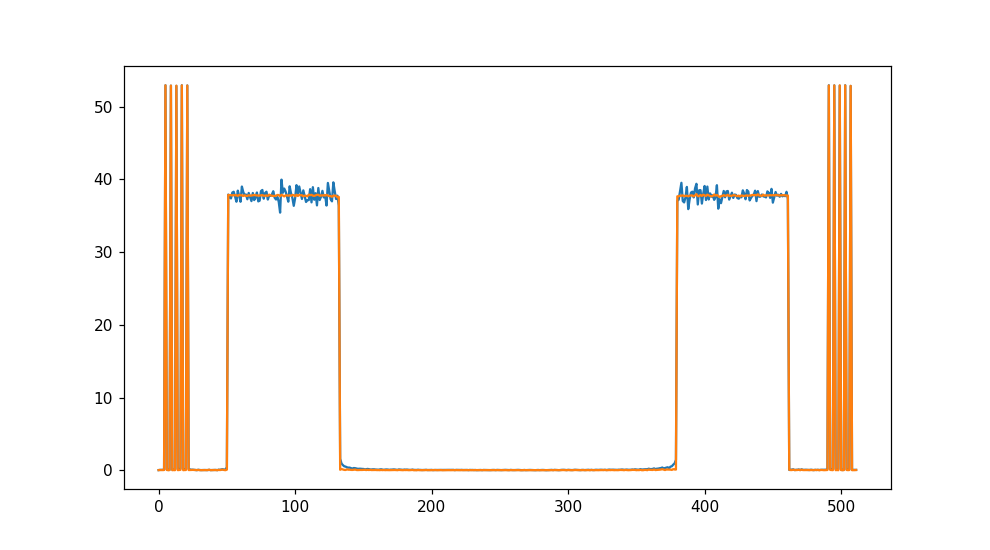

<IPython.core.display.Javascript object>


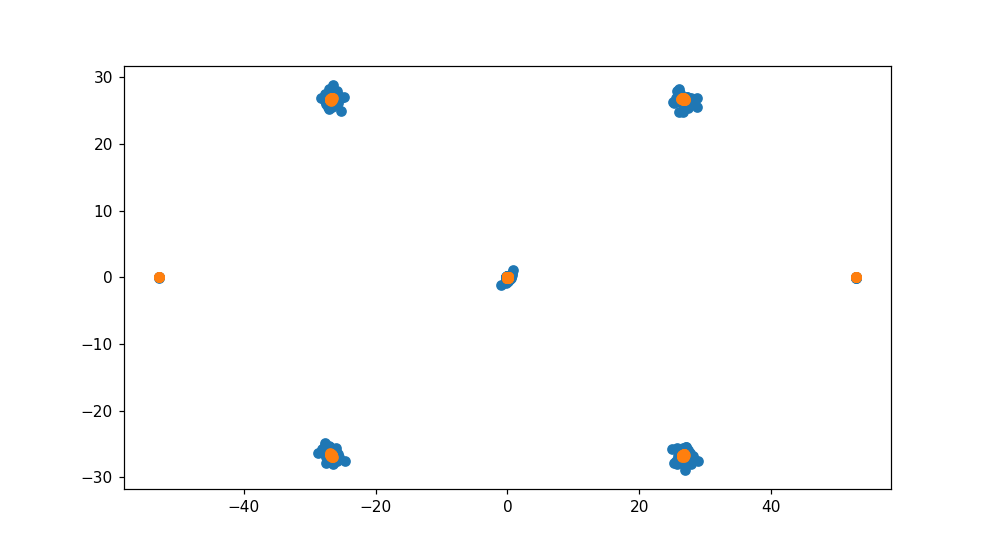

In [7]:
%matplotlib notebook

ofdm_sym_t_old = frame_t[preamble_sz + nguard//2: preamble_sz + nguard//2+nfft]
ofdm_sym_f_old = np.fft.fft(ofdm_sym_t_old)
ofdm_sym_f_old *= np.exp(2j*np.pi*np.arange(nfft)*(nguard - nguard//2)/nfft)
ofdm_sym_f_old = ofdm_precise_syn(ofdm_sym_f_old)

ofdm_sym_t = ynew[preamble_sz + nguard//2: preamble_sz + nguard//2+nfft]
ofdm_sym_f = np.fft.fft(ofdm_sym_t)
ofdm_sym_f *= np.exp(2j*np.pi*np.arange(nfft)*(nguard - nguard//2)/nfft)
ofdm_sym_f = ofdm_precise_syn(ofdm_sym_f)

plt.figure(figsize=(9, 5))
plt.plot(np.abs(ofdm_sym_f_old))
plt.plot(np.abs(ofdm_sym_f))

plt.figure(figsize=(9, 5))
plt.scatter(ofdm_sym_f_old.real, ofdm_sym_f_old.imag)
plt.scatter(ofdm_sym_f.real, ofdm_sym_f.imag)

<IPython.core.display.Javascript object>


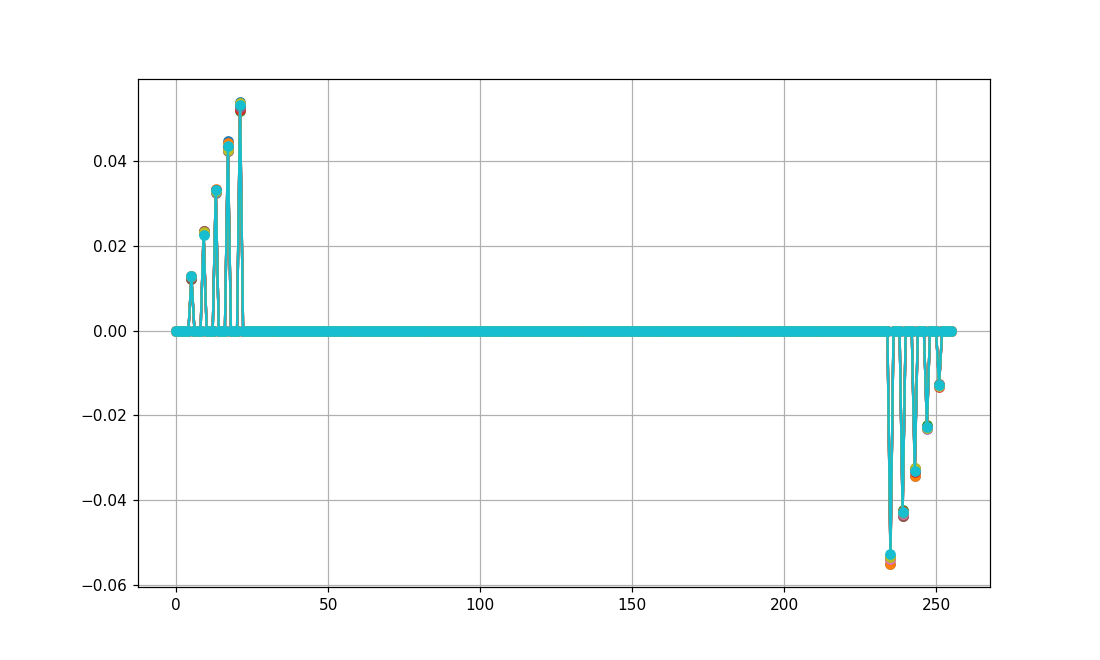

9.960884694373982e-07
9.954450908504549e-07
9.70519978697275e-07
9.810148190601729e-07
9.818213233419392e-07
9.82332591612761e-07
9.825422191771072e-07
9.72999999303239e-07
9.832026293571242e-07
9.778888379480927e-07


In [21]:


%matplotlib notebook


fig = plt.figure(figsize=(10, 6))


for frame_idx in range(-200, -190):
    frame_t = data_frames[frame_idx]
    sym_first_f = np.fft.fft(
        frame_t[preamble_sz + nguard//2: preamble_sz + nguard//2 + nfft])
    sym_last_f = np.fft.fft(
        frame_t[preamble_sz + nguard//2 + (nfft+nguard)*(frame_sym_cnt-1): (nfft+nguard)*(frame_sym_cnt-1) + preamble_sz + nguard//2 + nfft])


    #ang_diff = np.angle(sym_last_f) - np.angle(sym_first_f)
    ang_diff = np.angle(sym_first_f.conj()*sym_last_f)
    ang_diff[ang_diff < -np.pi] += 2*np.pi

    pilot_carriers_idx_non_sym = pilot_carriers_idx.copy()
    pilot_carriers_idx_non_sym[pilot_carriers_idx_non_sym<0] = pilot_carriers_idx_non_sym[pilot_carriers_idx_non_sym<0] + nfft
    
    ang_diff[np.setdiff1d(np.arange(nfft), pilot_carriers_idx_non_sym)] = 0
    plt.plot(np.arange(ang_diff.size), ang_diff, 'o-')
    plt.grid(True)
    sco_est2 = OFDM_OOT.ofdm_sco_sync.sco_estimate_frame2(frame_t[preamble_sz:], nfft, nguard, frame_sym_cnt, pilot_carriers_idx)
    print(sco_est2)


<IPython.core.display.Javascript object>


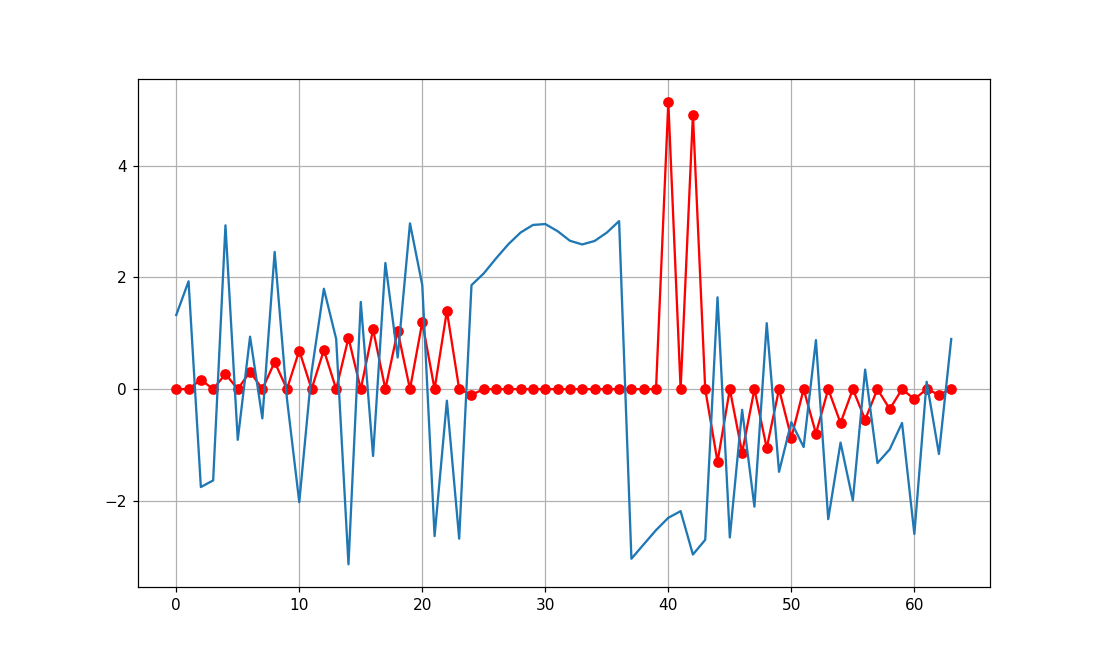

In [29]:
%matplotlib notebook

frame1_idx = -100
frame_idx_diff = 10
frame1 = data_frames[frame1_idx]
frame2 = data_frames[frame1_idx + frame_idx_diff]
preamble_1_t = frame1[nguard//2:nguard//2+nfft]
preamble_2_t = frame2[nguard//2:nguard//2+nfft]
preamble_1_f = np.fft.fft(preamble_1_t)
preamble_2_f = np.fft.fft(preamble_2_t)


fig = plt.figure(figsize=(10, 6))
ang_diff = np.angle(preamble_2_f) - np.angle(preamble_1_f)
ang_diff[ang_diff < -np.pi] += 2*np.pi
ang_diff[np.abs(ofdm_preamble_f)<1e-6] = 0
plt.plot(np.arange(ang_diff.size), ang_diff, 'ro-')
plt.plot(np.angle(preamble_1_f))
plt.grid(True)


In [12]:
ang_est = ang_diff[np.abs(ofdm_preamble_f)>1e-6] 
ang_est_idx = np.arange(ang_diff.size)[np.abs(ofdm_preamble_f)>1e-6]
ang_est_idx[ang_est_idx>ang_diff.size//2] = nfft - ang_est_idx[ang_est_idx>ang_diff.size//2]

print(np.mean(np.abs(ang_est/np.abs(ang_est_idx))))

0.013835765529165989


In [18]:
0.013/(frame_sz+200)/10/(2*np.pi)*nfft

3.678247573679359e-05

In [1]:
from gnuradio.OFDM_OOT import ofdm_preambles

ImportError: cannot import name 'ofdm_sco_sync' from 'gnuradio.OFDM_OOT.ofdm_sco_sync' (/usr/local/lib/python3.10/dist-packages/gnuradio/OFDM_OOT/ofdm_sco_sync.py)

In [2]:
ofdm_preambles.cox_schmerzmittel_cfg()

NameError: name 'ofdm_preambles' is not defined

In [26]:
def f(a, b, c):
    print(a)
    print(b)
    print(c)

f(10, *(1, 2))

10
1
2


<IPython.core.display.Javascript object>


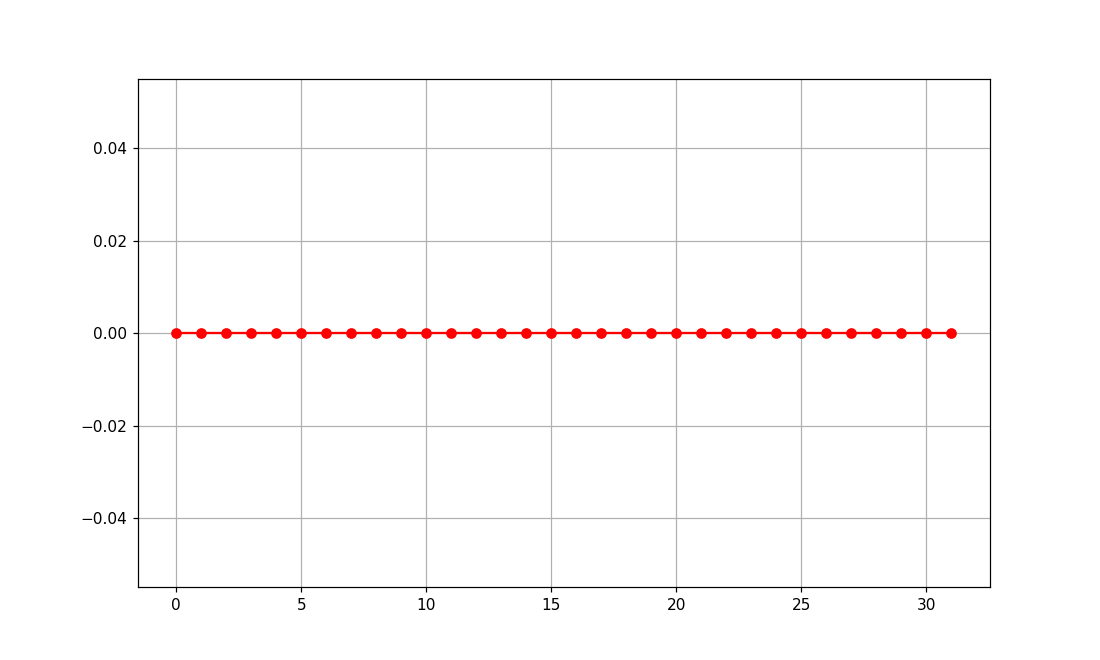

In [15]:
%matplotlib notebook

frame_idx = -100
frame = data_frames[frame1_idx]
preamble_1_t = frame[nguard//2:nguard//2+nfft//2]
preamble_2_t = frame[nguard//2+nfft//2:nguard//2+nfft]
preamble_1_f = np.fft.fft(preamble_1_t)
preamble_2_f = np.fft.fft(preamble_2_t)


fig = plt.figure(figsize=(10, 6))
ang_diff = np.angle(preamble_2_f) - np.angle(preamble_1_f)
ang_diff[ang_diff < -np.pi] += 2*np.pi
ang_diff[np.abs(preamble_1_f)<1e-6] = 0

plt.plot(np.arange(ang_diff.size), ang_diff, 'ro-')
plt.grid(True)


In [18]:
ang_diff

array([ 0.        ,  0.        ,  0.00306797,  0.        ,  0.0061348 ,
        0.        ,  0.00920201,  0.        ,  0.01227298,  0.        ,
        0.01534514,  0.        ,  0.01840947,  0.        ,  0.02146699,
        0.        ,  0.02457129,  0.        ,  0.02788573,  0.        ,
        0.03175305,  0.        ,  0.03680171,  0.        ,  0.04420296,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.0442029 ,  0.        , -0.03680176,  0.        , -0.03175305,
        0.        , -0.02788561,  0.        , -0.02457127,  0.        ,
       -0.02146692,  0.        , -0.01840946,  0.        , -0.01534509,
        0.        , -0.0122729 ,  0.        , -0.00920204,  0.        ,
       -0.00613472,  0.        , -0.00306801,  0.        ])

In [1]:
import gnuradio